In [ ]:
! pip install segmentation_models_pytorch albumentations
! pip install -U git+https://github.com/albu/albumentations --no-cache-dir

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import albumentations
import torchvision 
import random
import segmentation_models_pytorch as smp
#from lib.pytorchtools import *

In [ ]:
#Mount Google Drive with dataset
from google.colab import drive
drive.mount('/content/drive/')

#Define pathes to images and corresponding masks intended to train and validate model
trainpath_images = "/content/drive/MyDrive/train_images_512x512_npy/images/"
trainpath_masks = "/content/drive/MyDrive/train_images_512x512_npy/masks/"

#Collect all pathes to images and masks in two lists
masks = [os.path.join(trainpath_masks, i) for i in os.listdir(trainpath_masks)]
imgs = [os.path.join(trainpath_images, i) for i in os.listdir(trainpath_images)]

#Sort pathes to images and masks in order images correspond to masks
masks.sort()
imgs.sort()

#Split dataset on train and validation parts (ratio 85:15)
df = pd.DataFrame({"image":imgs, "mask":masks})
df_train, df_val = train_test_split(df, test_size = 0.15)

#Check out size of train and validation datasets
print(df_train.values.shape)
print(df_val.values.shape)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
(8126, 2)
(1434, 2)


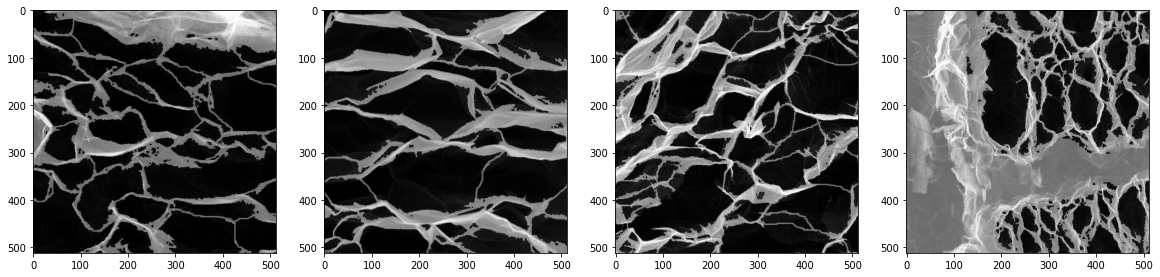

In [ ]:
#Plot some images with superimposed corresponding masks
rows, cols = 1, 4
fig = plt.figure(figsize = (20, 20))
for i in range(1, rows * cols + 1):
    idx = random.randint(0, len(df))
    fig.add_subplot(rows, cols, i)
    img_path = df['image'][idx]
    msk_path = df['mask'][idx]
    plt.imshow(np.load(img_path), cmap = 'gray')
    plt.imshow(np.load(msk_path), alpha = 0.4, cmap = 'gray')
plt.show()

In [ ]:
def convert_to_tensor(x, **kwargs):
    """
    Reshape numpy tensor from (H, W) to (C=1, H, W).
    
    Parameters
    ----------
    x: ndarray of shape (H, W).
        Image in tensor form.

    Returns
    -------
    ndarray(dtype='float32') of shape (C=1, H, W).
        Reshaped image in tensor form.
    """

    return np.expand_dims(x, axis=0).astype("float32")


def func_for_preprocessing(preprocessing_fn=None):
    """
    Generates a set of albumentations' transforms to preprocess images.
    
    Parameters
    ----------
    preprocessing_fn: function, optional, default=None
        Function used to preprocess raw images.

    Returns
    -------
    An instance of albumentations' Compose class containing preprocessing functions.
    """

    transform = []
    if preprocessing_fn:
        transform.append(albumentations.Lambda(image=preprocessing_fn))
    transform.append(albumentations.Lambda(image=convert_to_tensor, mask=convert_to_tensor))
    return albumentations.Compose(transform)


def trainaugs():
    """
    Generates a set of albumentations' transforms to augment train dataset.
    
    Returns
    -------
    An instance of albumentations' Compose class containing augmenting functions.
    """
    
    transform = [
                albumentations.HorizontalFlip(p=0.5),
                albumentations.VerticalFlip(p=0.5),
            ]
    return albumentations.Compose(transform)


def valaugs():
    """
    Generates a set of albumentations' transforms to augment validation dataset.
    
    Returns
    -------
    An instance of albumentations' Compose class containing augmenting functions.
    """

    transform = [
                albumentations.HorizontalFlip(p=0.5),
                albumentations.VerticalFlip(p=0.5),
            ]
    return albumentations.Compose(transform)


class MyDataset(Dataset):
    """
    Class used to represent train/validation dataset applying preprocessing and augmentation.
    
    Attributes
    ----------
    imagespath: list of length N.
        Contains all pathes to raw images.
    maskspath: list of length N.
        Contains all pathes to raw masks.
    augment: albumentations' Compose class, optional, default=None.
        Contains augmenting functions.
    preprocess: albumentations' Compose class, optional, default=None.
        Contains preprocessing functions.        
    """

    def __init__(self, imagespath, maskspath, augment=None, preprocess=None):
        self.imagespath = imagespath
        self.maskspath = maskspath
        self.augment = augment
        self.preprocess = preprocess

        
    def __len__(self):
        """
        Measures object's length (dataset size).

        Returns
        -------
        int.
            Dataset size.
        """

        return len(self.imagespath)

    
    def __getitem__(self, idx):
        """
        Opens, augments, preprocesses and returns idx-th tuple of image and mask.

        Parameters
        ----------
        idx: int.
            Index number of image and corresponding mask.

        Returns
        -------
        Tuple of length 2.
            Augmented and preprocessed image and corresponding mask.
        """

        #Open npy-files with image and mask
        image = np.load(self.imagespath[idx])
        mask = np.load(self.maskspath[idx])
        
        #Augment image and mask
        if self.augment:
            sample = self.augment(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        #Preprocess image and mask
        if self.preprocess:
            sample = self.preprocess(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask


def plot_metrics(train_logs, valid_logs, metric):
    """
    Plot train/validation metrics and/or loss function values.
    
    Parameters
    ----------
    train_logs: pandas' DataFrame.
        Table of train metrics.
    valid_logs: pandas' DataFrame.
        Table of validation metrics.
    metric: str.
        Metric's name.
    """

    plt.figure(figsize=(10,4))
    plt.plot(train_logs.index.tolist(), train_logs[metric].tolist(), 'b', lw=2, label = 'Train')
    plt.plot(valid_logs.index.tolist(), valid_logs[metric].tolist(), 'r' , lw=2, label = 'Valid')
    plt.xlabel('Epochs', fontsize=20)
    plt.ylabel(metric.capitalize(), fontsize=20)
    plt.title(metric.capitalize() + ' Plot', fontsize=20)
    plt.legend(loc='best', fontsize=16)
    plt.grid()
    plt.show()

In [ ]:
#Define encoder and activation function
encoder = "efficientnet-b4"
activation = "sigmoid"

#Define model
model = smp.FPN(encoder_name=encoder, activation=activation, encoder_weights=None, encoder_depth=5, in_channels=1)

#Define preprocessing function and construct train and validation pytorch datasets applying augmentation 
preprocess_func = None
traindata = MyDataset(imagespath = df_train['image'].tolist(),
                            maskspath = df_train['mask'].tolist(),
                            augment = trainaugs(),
                            preprocess = func_for_preprocessing(preprocess_func))
validationdata = MyDataset(imagespath = df_val['image'].tolist(),
                           maskspath = df_val['mask'].tolist(),
                           augment = valaugs(),
                           preprocess = func_for_preprocessing(preprocess_func))

#Define batch size and construct train and validation pytorch dataloaders
batch_size = 11
trainloader = DataLoader(traindata, batch_size = batch_size, shuffle=True)
valloader = DataLoader(validationdata, batch_size = batch_size, shuffle=False)

In [ ]:
#Switch on train mode of model
#Define number of train epoches, device, loss function, other metrics of interest, optimizer
trainmodel = True
epochs = 100
device = "cuda"
loss = smp.utils.losses.DiceLoss()
metrics = [smp.utils.metrics.IoU(threshold=0.5)]
optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=0.001)])

#Initialize train and validation epoch
trainepoch = smp.utils.train.TrainEpoch(model, loss=loss, optimizer=optimizer, metrics=metrics, device=device, verbose=True)
validepoch = smp.utils.train.ValidEpoch(model, loss=loss, metrics=metrics, device=device, verbose=True)

In [ ]:
#Run train/validation process
#Detect the best model with the highest IoU score on validation dataset
train_logs_list, valid_logs_list = [], []
best_model = model
best_result = 0.0
for i in range(0, epochs):
    print('\nEpoch: {}'.format(i))
    trainlogs = trainepoch.run(trainloader)
    validlogs = validepoch.run(valloader)
    train_logs_list.append(trainlogs)
    valid_logs_list.append(validlogs)   
    if best_result < validlogs['iou_score']:
        best_result = validlogs['iou_score']
        best_model = model


Epoch: 0
valid: 100%|██████████| 131/131 [13:48<00:00,  6.33s/it, dice_loss - 0.1391, iou_score - 0.7596]

Epoch: 1
valid: 100%|██████████| 131/131 [00:33<00:00,  3.94it/s, dice_loss - 0.1191, iou_score - 0.7897]


In [ ]:
#Save weights of the best model and model corresponding to the last train epoch
torch.save(best_model.state_dict(), '/content/drive/MyDrive/best_model_MAnet_efficientnet-b4_ep50_bs10_wc_wlrsch_lr0_001.pth')
torch.save(model.state_dict(), '/content/drive/MyDrive/model_MAnet_efficientnet-b4_ep50_bs10_wc_wlrsch_lr0_001.pth')

In [ ]:
#Save train/validation metrics and loss function values
train_logs_df.to_csv('/content/drive/MyDrive/train_metrics_MAnet_efficientnet-b4_ep50_bs10_wc_wlrsch_lr0_001.csv', sep='\t')
valid_logs_df.to_csv('/content/drive/MyDrive/valid_metrics_MAnet_efficientnet-b4_ep50_bs10_wc_wlrsch_lr0_001.csv', sep='\t')

In [ ]:
#Check out train/validation metrics and loss function values
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.T

,0,1
dice_loss,0.159299,0.127807
iou_score,0.730369,0.776349


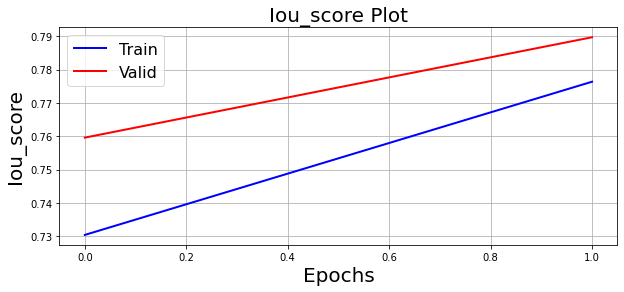

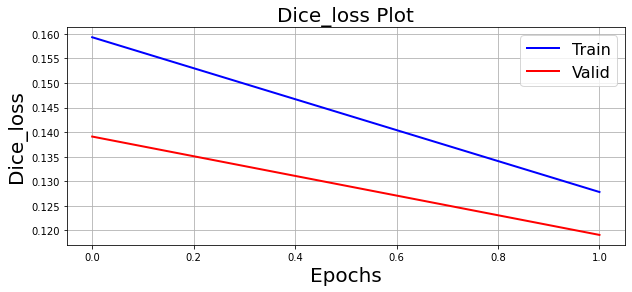

In [ ]:
#Plot train/validation metrics and loss function values
for metric in metrics:
    plot_metrics(train_logs_df, valid_logs_df, metric.__name__)
plot_metrics(train_logs_df, valid_logs_df, loss.__name__)

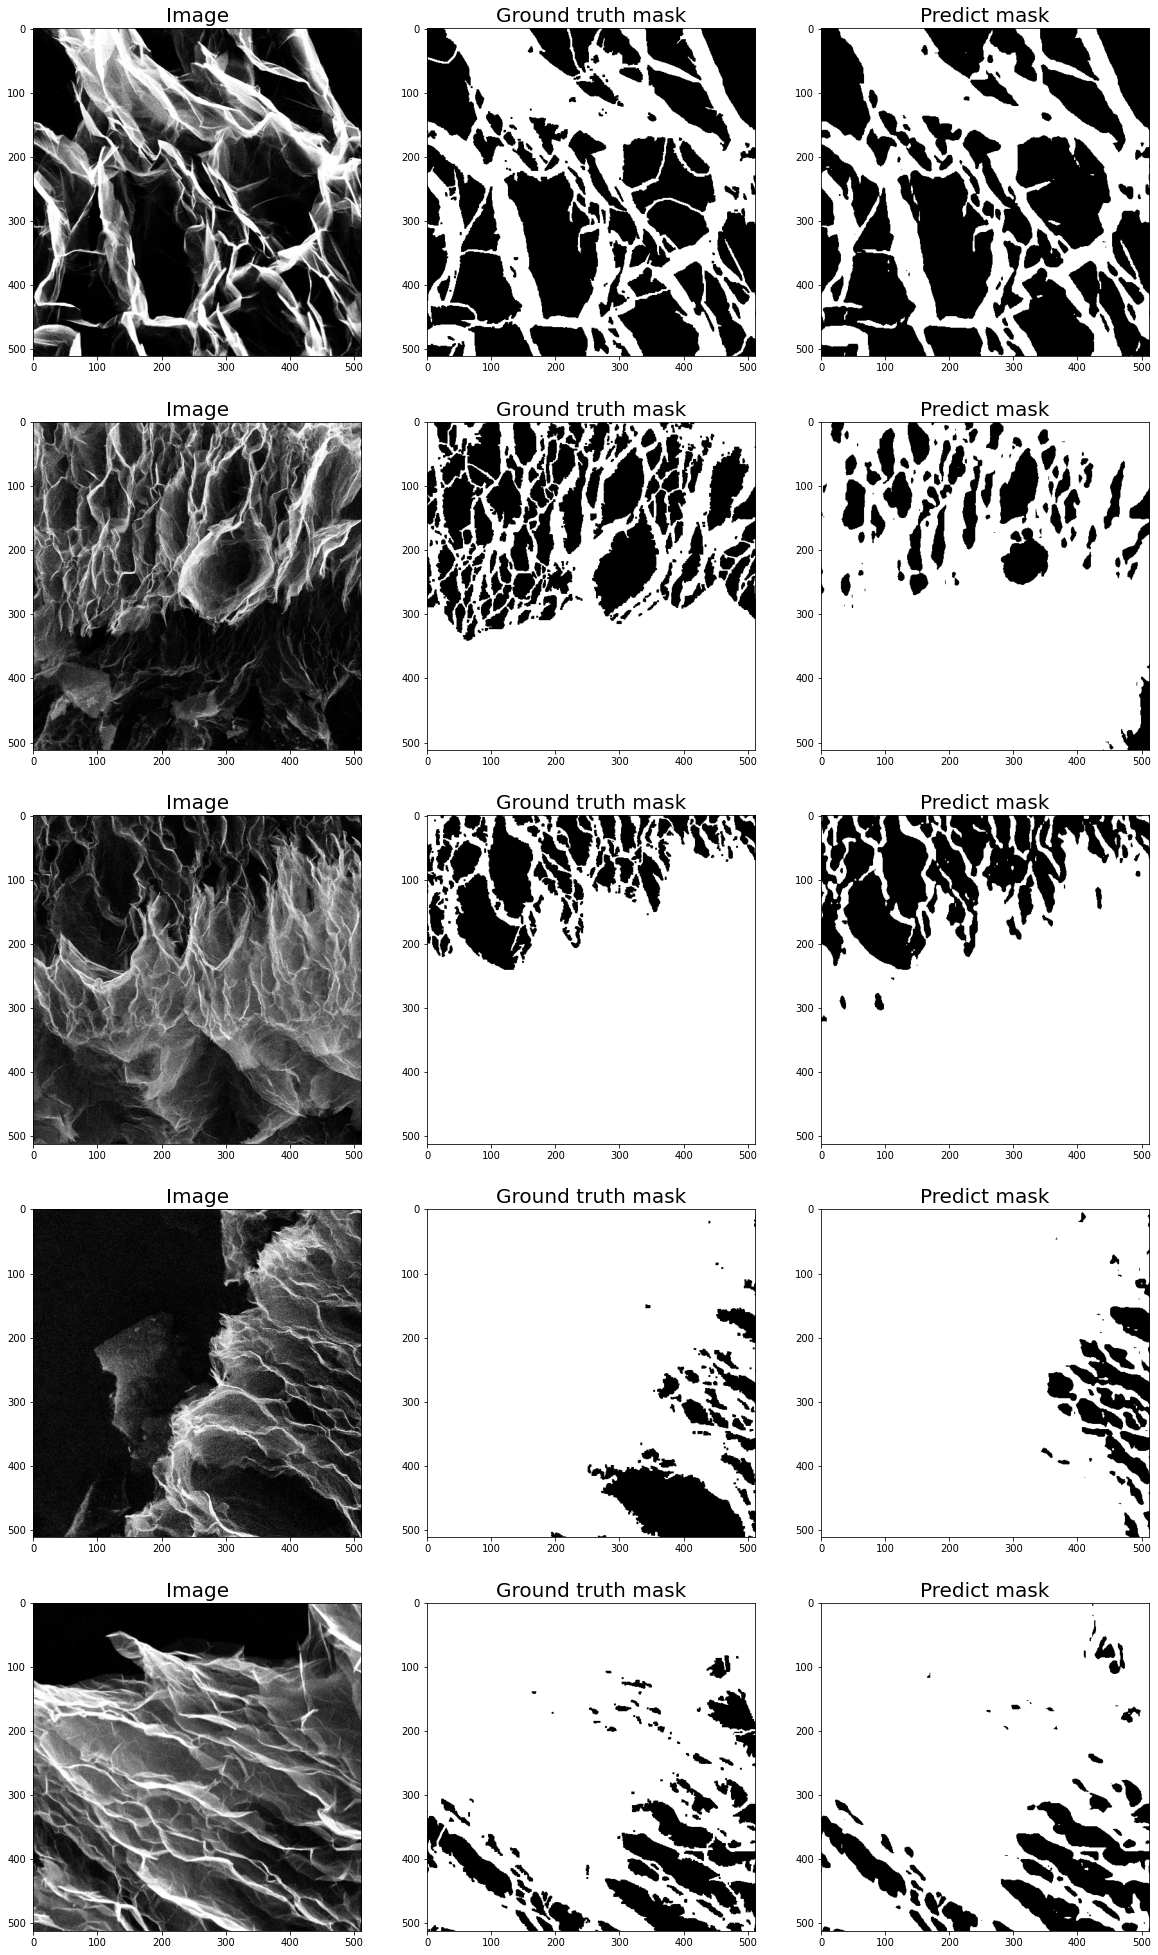

In [ ]:
#Plot some images, ground truth masks and predicted masks using best_model
best_model.eval()
num_examples = 5
fig, ax = plt.subplots(num_examples, 3, figsize=(20, 7 * num_examples))
for i in range(num_examples):
    idx = random.randint(0, len(df))
    img = np.load(df['image'][idx])
    mask = np.load(df['mask'][idx])
    ax[i, 0].imshow(img, cmap='gray')
    ax[i, 0].set_title('Image', fontsize=20)
    ax[i, 1].imshow(mask, cmap='gray')
    ax[i, 1].set_title('Ground truth mask', fontsize=20)
    img = convert_to_tensor(img)
    img = torch.from_numpy(img).to(device).unsqueeze(0)
    pred = best_model.predict(img)
    pred = pred.squeeze().cpu().detach().numpy().round().astype('uint8')
    ax[i, 2].imshow(pred, cmap='gray')
    ax[i, 2].set_title('Predict mask', fontsize=20)
plt.show()